In [91]:

from math import cos, sin, tau
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature


In [3]:
from shapes.reuleaux import get_angle

In [4]:
def mk_control_points(n_sides, center, radius, theta_offset=0.0, radius_y=None):
    angle_delta = tau / n_sides
    pts = []
    if radius_y is None:
        r2 = radius
    else:
        r2 = radius_y
    for i in range(n_sides):
        theta = theta_offset + i * angle_delta
        pts.append(
            (center[0] + radius * cos(theta), center[1] + r2 * sin(theta)))
    return pts

In [5]:
control_points = mk_control_points(5, [90., 80.], 3.5, 7)
print(control_points)

[(92.63865789020157, 82.29945309551576), (88.6284802800085, 83.22008286503227), (86.51369630660295, 79.69066756166532), (89.21686554236783, 76.58873917425402), (93.00229998081916, 78.20105730353262)]


In [6]:
def index_picker(n):
    """Generate a list of indicies for generating a Reuleaux-like polygon"""
    start_offset = int(n / 2)
    for i in range(n):
        yield i, (i + start_offset) % n, (i + start_offset + 1) % n,


In [7]:
def make_reuleaux_like(pts):
    """Generate the outline of a reuleaux-like polygon. The path described by the points is closed by
    virtue of having the first and last points the same."""
    n_points = len(pts)
    outline_points = []
    for indices in index_picker(n_points):
        center = pts[indices[0]]
        start = pts[indices[1]]
        end = pts[indices[2]]

        start_angle, start_radius, end_angle, end_radius = get_angle(center, start, end)
        angle_delta = end_angle - start_angle
        radius_delta = end_radius - start_radius
        arc_steps = int(max(start_radius, end_radius) * angle_delta + 0.5) * 10

        for i in range(arc_steps + 1):
            t = i / arc_steps;
            theta = start_angle + t * angle_delta
            radius = start_radius + t * radius_delta
            outline_points.append(
                [center[0] + radius * cos(theta), center[1] + radius * sin(theta)])
    outline_points.append(outline_points[0])
    return outline_points

In [93]:
def advance_reuleaux_ctl(pts, delta, jitter=False):
    """Generate the outline of a reuleaux-like polygon. The path described by the points is closed by
    virtue of having the first and last points the same.

    delta is percentage along side
    """
    n_points = len(pts)
    new_points = []
    base_delta = delta
    for indices in index_picker(n_points):
        center = pts[indices[0]]
        start = pts[indices[1]]
        end = pts[indices[2]]

        start_angle, start_radius, end_angle, end_radius = get_angle(center, start, end)
        angle_delta = end_angle - start_angle
        radius_delta = end_radius - start_radius
        arc_steps = int(max(start_radius, end_radius) * angle_delta + 0.5) * 10

        if jitter:
            delta = base_delta + random.uniform(-base_delta, base_delta)
        theta = start_angle + delta * angle_delta
        radius = start_radius + delta * radius_delta
        new_points.append(
            [center[0] + radius * cos(theta), center[1] + radius * sin(theta)])
    end_point = new_points.pop(0)
    new_points.append(end_point)
    return new_points

In [94]:
outline = make_reuleaux_like(control_points)

In [62]:
radius_delta = 0.3
theta = 0.
sides = 7
theta_delta = -(tau * .02)
center_x = 152.4 / 2.0
center_y = 101.6 / 2.0
radius = min(center_x, center_y) * .9
radius_y = None

plt.figure(figsize=(20, 20))
plt.axes().set_aspect('equal')

dest = open("/tmp/demo2.gcode", "w")
dest.write("G10 L20 P1 X0 Y0 Z0\n")
dest.write("G54\n")
dest.write("F1000\n")

while radius > 5:
    control_points = mk_control_points(sides, [center_x, center_y], radius, theta,
                                       radius_y=radius_y)
    outline = make_reuleaux_like(control_points)
    radius -= radius_delta
    # radius_y -= radius_delta
    theta += theta_delta
    plt.plot([x[0] for x in outline], [x[1] for x in outline], 'b')

    dest.write(f"G0 Z1 F1000\n")
    dest.write(f"G0 X{outline[0][0]} Y{outline[0][1]} F1000\n")
    dest.write(f"G1 Z0 F1000\n")
    for pt in outline[1:]:
        dest.write(f"G1 X{pt[0]} Y{pt[1]} F1000\n")
    # dest.write(f"G1 X{outline[0][0]} Y{outline[0][1]} F1000\n")
    dest.write(f"G0 Z1 F1000\n\n")
dest.write("G0 X0 Y0 F1000\n")
dest.write("G0 Z1 F1000\n")
dest.close()

plt.show()

In [47]:
101.6 / 2.0 * .9

45.72

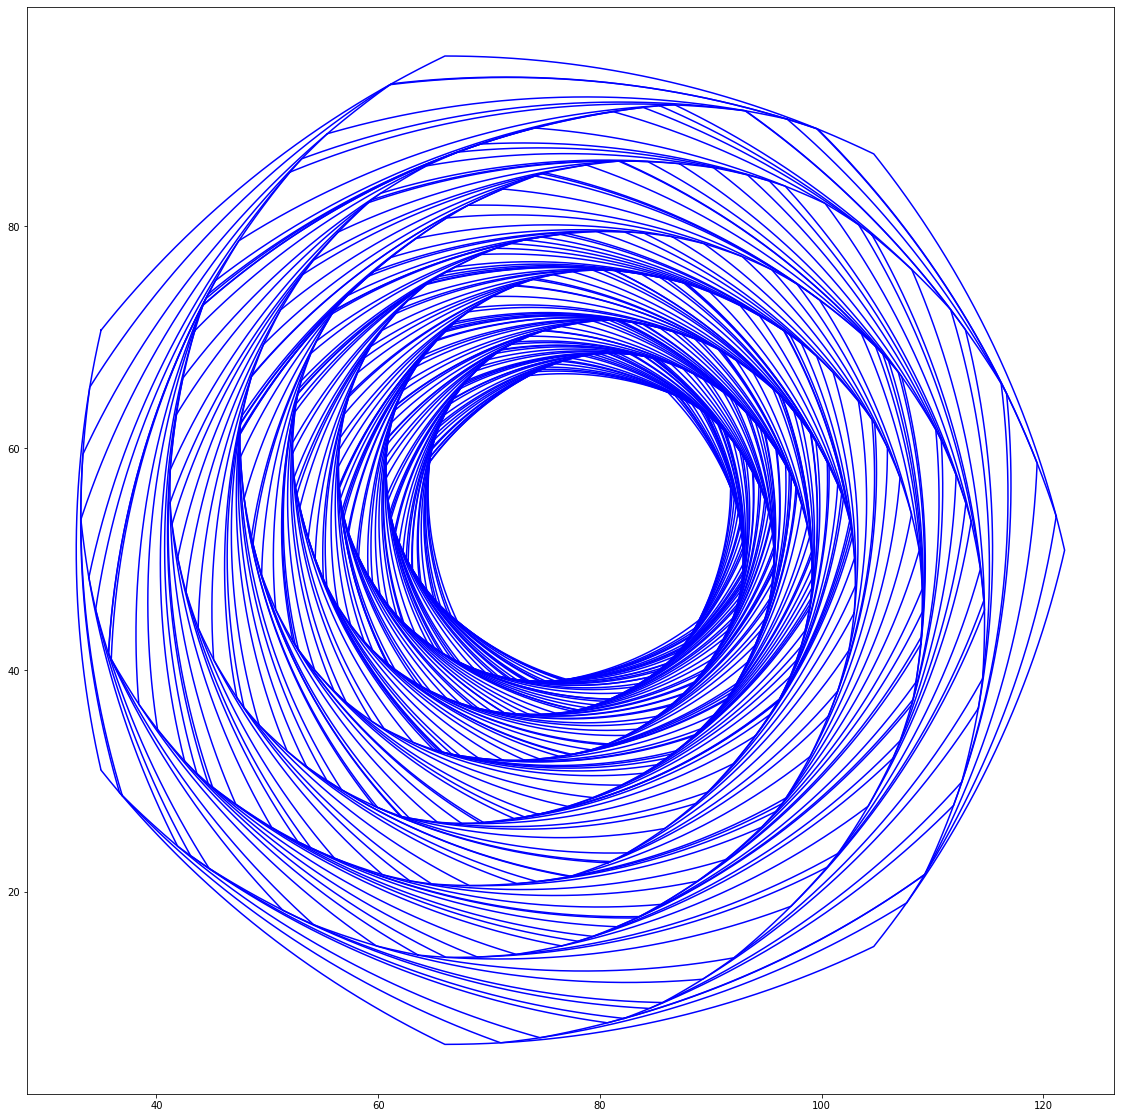

In [98]:

radius_delta = 0.8
theta = 0.
sides = 7
theta_delta = -(tau * .012)
center_x = 152.4 / 2.0
center_y = 101.6 / 2.0
radius = min(center_x, center_y) * .9

plt.figure(figsize=(20, 20))
plt.axes().set_aspect('equal')

dest = open("/tmp/demo2.gcode", "w")
dest.write("G10 L20 P1 X0 Y0 Z1\n")
dest.write("G54\n")
dest.write("F1000\n")
control_points = None
delta = .1
while radius > 10:
    if not control_points:
        control_points = mk_control_points(sides, [center_x, center_y], radius, theta)
    else:
        control_points = advance_reuleaux_ctl(control_points, delta, jitter=True)
        radius = ((control_points[0][0] - control_points[1][0]) ** 2 + (
                    control_points[0][1] - control_points[1][1]) ** 2) ** 0.5
        delta = delta * .99
    outline = make_reuleaux_like(control_points)
    radius -= radius_delta
    # radius_y -= radius_delta
    theta += theta_delta
    plt.plot([x[0] for x in outline], [x[1] for x in outline], 'b')

    dest.write(f"G0 Z1 F1000\n")
    dest.write(f"G0 X{outline[0][0]} Y{outline[0][1]} F1000\n")
    dest.write(f"G1 Z0 F1000\n")
    for pt in outline[1:]:
        dest.write(f"G1 X{pt[0]} Y{pt[1]} F1000\n")
    # dest.write(f"G1 X{outline[0][0]} Y{outline[0][1]} F1000\n")
    dest.write(f"G0 Z1 F1000\n\n")
dest.write("G0 X0 Y0 F1000\n")
dest.write("G0 Z1 F1000\n")
dest.close()

plt.show()

In [12]:
# Generate noisy image of a square
image = np.zeros((128, 128), dtype=float)
image[32:-32, 32:-32] = 1

import os
from skimage.color import rgb2gray

filename = os.path.join("/Users/paula/Pictures/Avatars", "cloud_toaster.JPG")
from skimage import io

image = rgb2gray(io.imread(filename))

# image = ndi.rotate(image, 15, mode='constant')
# image = ndi.gaussian_filter(image, 4)
# image = random_noise(image, mode='speckle', mean=0.1)

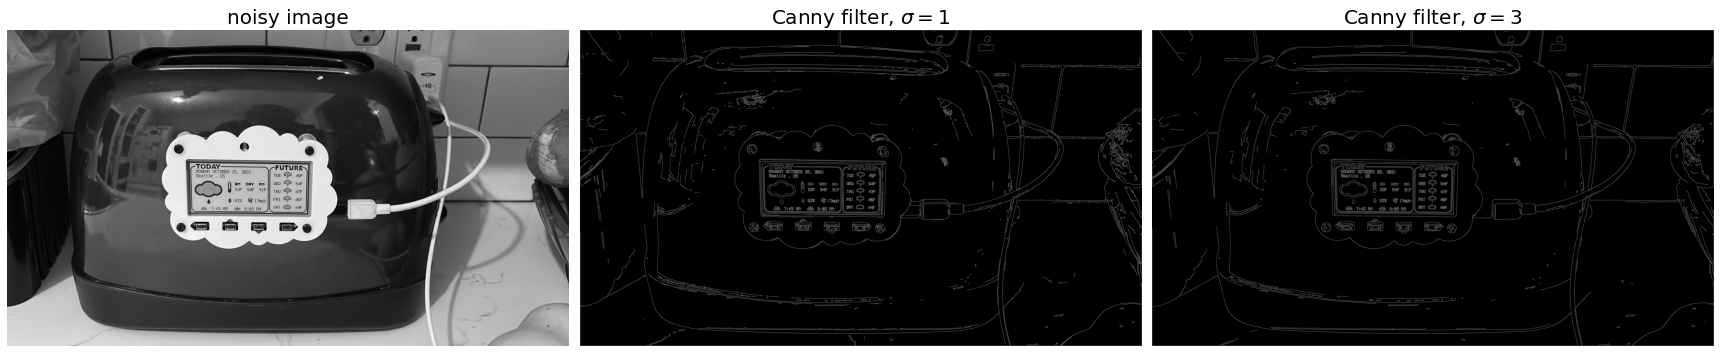

In [13]:

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=1.5)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 9))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [45]:
33 / .4

82.5